In [56]:
import numpy as np
import deepchem as dc
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import copy as cp
import time

def find_min_max_distance_and_ratio(x, vectors):
    # Calculate the squared differences between x and each vector in the list
    squared_diffs_x = np.sum((vectors - x)**2, axis=1)
    # Calculate the Euclidean distances between x and each vector in the list
    distances_x = np.sqrt(squared_diffs_x)
    # Calculate all pairwise squared differences among the vectors in the list
    pairwise_diffs = np.sum((vectors[:, np.newaxis, :] - vectors[np.newaxis, :, :])**2, axis=-1)
    # Calculate the pairwise Euclidean distances among the vectors in the list
    pairwise_distances = np.sqrt(pairwise_diffs)
    # Find the minimal distance
    min_distance = np.min(distances_x)
    # Find the maximal distance among all vectors, including x
    max_distance = np.max([np.max(pairwise_distances), np.max(distances_x)])
    # Calculate the ratio p = min_distance / max_distance
    p = min_distance / max_distance
    return p

# Optimized function using scipy.spatial.distance.cdist
def find_min_max_distance_and_ratio_scipy(x, vectors):
    # Calculate the minimum distance between x and vectors using cdist
    dist_1 = distance.cdist([x], vectors, 'euclidean')
    min_distance = np.min(dist_1)
    # Calculate the maximum distance among all vectors and x using cdist
    pairwise_distances = distance.cdist(vectors, vectors, 'euclidean')
    max_distance_vectors = np.max(pairwise_distances)
    max_distance_x = np.max(dist_1)
    max_distance = max(max_distance_vectors, max_distance_x)
    # Calculate the ratio p = min_distance / max_distance
    p = min_distance / max_distance

    return p


size = 128
featurizer = dc.feat.CircularFingerprint(size=size)
tasks, datasets, transformers = dc.molnet.load_sampl(featurizer=featurizer, splitter='random', transformers = [])
train_dataset, valid_dataset, test_dataset = datasets
SMILES_train,SMILES_valid, SMILES_test = np.array(train_dataset.ids), np.array(valid_dataset.ids), np.array(test_dataset.ids)
SMILES = np.concatenate([SMILES_train, SMILES_valid, SMILES_test])
X_train, X_valid, X_test = train_dataset.X, valid_dataset.X, test_dataset.X
X = np.concatenate([X_train, X_valid, X_test])

#create dummy vector x_dummy that only contains 1s
X_dummy = np.ones((1, size))
X_dummy_2 = X_dummy+0.5


#select 10 random molecules as X_train, rest as X_test
X_train, X_test, SMILES_train, SMILES_test = train_test_split(X, SMILES, train_size=200, random_state=42)

#take a random molecule from X_test as x
#select 10 random indices from the range of X_test
costy_mols = []
for _ in range(7):
    ind = np.random.randint(0, len(X_test))
    x_random = X_test[ind]
    X_test = np.delete(X_test, ind, axis=0)
    costy_mols.append(x_random)

In [34]:
import numpy as np
from scipy.spatial import distance

# Generate a random X_train of shape (200, 128) for demonstration
X_train = np.random.rand(200, 128)

# Step 1: Calculate the maximum pairwise distance within X_train
pairwise_distances = distance.cdist(X_train, X_train, 'euclidean')
np.fill_diagonal(pairwise_distances, 0)  # Set diagonal to zero to exclude distance from a point to itself
d_max = np.max(pairwise_distances)

# Step 2: Calculate distances from each vector in X_train to the origin
dist_to_origin = np.linalg.norm(X_train, axis=1)

# Step 3: Select a vector that maximizes (d + d_max)
selected_vector_index = np.argmax(dist_to_origin + d_max)
selected_vector = X_train[selected_vector_index]

# Step 4: Generate x_far by moving from the selected vector by d_max in some direction (e.g., along one axis)
x_far = selected_vector + d_max * np.ones_like(selected_vector)


In [57]:
start = time.time()
costs_scale_1 = np.array([find_min_max_distance_and_ratio(x, np.concatenate((X_train, X_dummy))) for x in X_test])
end = time.time()
print(end - start)


start = time.time()
costs_scale_2 = np.array([find_min_max_distance_and_ratio_scipy(x, np.concatenate((X_train, X_dummy))) for x in X_test])
end = time.time()
print(end - start)


#check if the two arrays are equal for all entries
np.array_equal(costs_scale_1, costs_scale_2)
print(np.array_equal(costs_scale_1, costs_scale_2))

4.6742846965789795
0.4976813793182373
True


In [58]:
import random

X_train_cp = cp.deepcopy(X_train)
X_test_cp  = cp.deepcopy(X_test)

all_running_costs = []
for x in costy_mols:
    running_costs = []
    #for x_test in X_test[random_indices][:10]:
    for inds in np.arange(1, len(X_test_cp)):
        X_train_cp = np.vstack( (X_train, X_test[:inds]) )
        costs = find_min_max_distance_and_ratio_scipy(x, X_train_cp)
        running_costs.append(costs)
    all_running_costs.append(running_costs)
all_running_costs = np.array(all_running_costs)

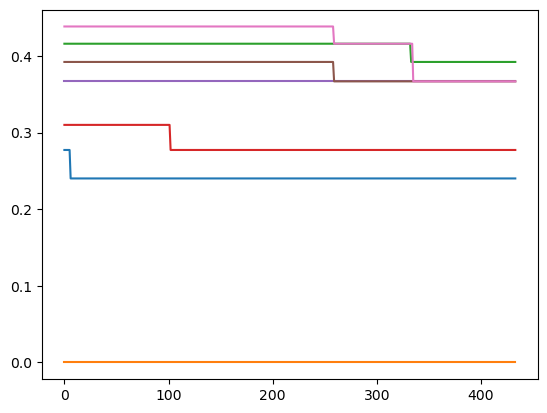

In [60]:
for i in range(7):
    plt.plot(all_running_costs[i])

In [61]:
X_train_cp = cp.deepcopy(X_train)
X_test_cp  = cp.deepcopy(X_test)


costs = 0

costs = find_min_max_distance_and_ratio_scipy(costy_mols[0], X_train_cp)
print(costs)
batch_price = costs
X_train_cp = np.vstack( (X_train_cp, costy_mols[0]) )


costs = find_min_max_distance_and_ratio_scipy(costy_mols[1], X_train_cp)
print(costs)
batch_price += costs
X_train_cp = np.vstack( (X_train_cp, costy_mols[1]) )

costs = find_min_max_distance_and_ratio_scipy(costy_mols[2], X_train_cp)
print(costs)
batch_price += costs
X_train_cp = np.vstack( (X_train_cp, costy_mols[2]) )


print(batch_price)

0.2773500981126146
0.0
0.41602514716892186
0.6933752452815365


In [62]:
import numpy as np
import copy as cp
import itertools

def get_batch_price(X_train, costy_mols):
    
    X_train_cp = cp.deepcopy(X_train)

    batch_price = 0  # Initialize batch price

    # Assuming find_min_max_distance_and_ratio_scipy is already defined

    for mol in costy_mols:
        costs = find_min_max_distance_and_ratio_scipy(mol, X_train_cp)
        
        batch_price += costs  # Update the batch price
        X_train_cp = np.vstack((X_train_cp, mol))

    return batch_price

get_batch_price(X_train, costy_mols)

2.2011230545371117

In [63]:
from tqdm import tqdm
all_permutations = list(itertools.permutations(costy_mols))

prices = []
for perm in tqdm(all_permutations):
    prices.append(get_batch_price(X_train, perm))

prices = np.array(prices)

100%|██████████| 5040/5040 [00:41<00:00, 120.90it/s]


In [64]:
np.min(prices)

2.2011230545371117

In [65]:
np.max(prices)

2.201123054537112

In [66]:
np.max(prices) - np.min(prices)

4.440892098500626e-16